# 2D Gaussian tomography

## Imports

In [1]:
#Imports

import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import string
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf
import keras
from keras.datasets import mnist
from keras import layers
from tensorflow.keras.utils import plot_model
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from skimage.metrics import structural_similarity as ssim
import matplotlib.cm as cm
from matplotlib.colors import Normalize
#import esmda_full
from scipy.optimize import minimize
from datetime import datetime

In [2]:
# input: (60000,28,28); output: (60000,28,28,1)
def reshape_for_CNN(coarse_train,coarse_test,dim):

  coarse_train=np.reshape(coarse_train, (len(coarse_train), dim[0], dim[1], 1))
  coarse_test=np.reshape(coarse_test, (len(coarse_test), dim[0], dim[1], 1))
  return coarse_train,coarse_test

In [3]:
# take in (60000,28,28) ; specify dim to upscale; coarsen, normalize;   output: either (x1*x2) or (x1, x2, 1)
def upscale_normalize_reshape(train_x,test_x,dim,cnn):
# dim=(n,n); 
# train_x.shape - (60000,28,28)

    train_x=train_x.astype('float32')
    test_x= test_x.astype('float32')

    #train_x=np.reshape(train_x, (len(train_x), int(train_x.shape[1]), int(train_x.shape[1]))) # if 
    #test_x=np.reshape(test_x, (len(test_x), int(test_x.shape[1]), int(test_x.shape[1])))

    # coarsen training data
    coarse_train=np.zeros((train_x.shape[0],dim[0],dim[1]))
    for i in range(train_x.shape[0]):
        coarse_train[i] = cv2.resize(train_x[i], dim, interpolation = cv2.INTER_AREA)
        
    #coarsen test data
    coarse_test=np.zeros((test_x.shape[0],dim[0],dim[1]))
    for i in range(test_x.shape[0]):
        coarse_test[i] = cv2.resize(test_x[i], dim, interpolation = cv2.INTER_AREA)

    # normalize
    coarse_train=coarse_train.astype('float32') / np.absolute(coarse_train).max()
    coarse_test=coarse_test.astype('float32') / np.absolute(coarse_test).max()
    
    if cnn==True:
        coarse_train,coarse_test=reshape_for_CNN(coarse_train,coarse_test,dim)
    else:
        coarse_train=np.reshape(coarse_train, (len(coarse_train), dim[0]*dim[1]))
        coarse_test=np.reshape(coarse_test, (len(coarse_test), dim[0]*dim[1]))
    return coarse_train, coarse_test

In [4]:
# take 2 images and plot: 1) top: original 2) bottom: reconstruction
def plot_reconstruction1(original,reconstruction,dim1,dim2):


  n = 10
  plt.figure(figsize=(20, 4))
  for i in range(n):
      # Display original
      ax = plt.subplot(2, n, i + 1)
      plt.imshow(original[i].reshape(dim1, dim2))
      plt.jet()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      plt.title('Original fine test')

      # Display reconstruction
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(reconstruction[i].reshape(dim1, dim2))
      plt.jet()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      plt.title('Reconstructed test')
  plt.colorbar()
  plt.show()

## Data Generation

In [5]:
gaussian_data = np.load(r'C:\Users\Mahammad\OneDrive\Desktop\USC_2021\Research\Data_assimilation\Multiscale_HM_ENKF\Multiscale_gradient_based\RSC_2023\Gaussian\gaussian_data_5000_16384.npy')
gaussian_data.shape

(5000, 16384)

In [6]:
# Split to train, test

x_train=gaussian_data[:4500]          # 450
print(x_train.shape)
x_test=gaussian_data[4500:]        # 50
print(x_test.shape)


x_train=np.reshape(x_train, (len(x_train),128, 128))
x_test=np.reshape(x_test, (len(x_test), 128, 128))
print(x_train.shape)
print(x_test.shape)

(4500, 16384)
(500, 16384)
(4500, 128, 128)
(500, 128, 128)


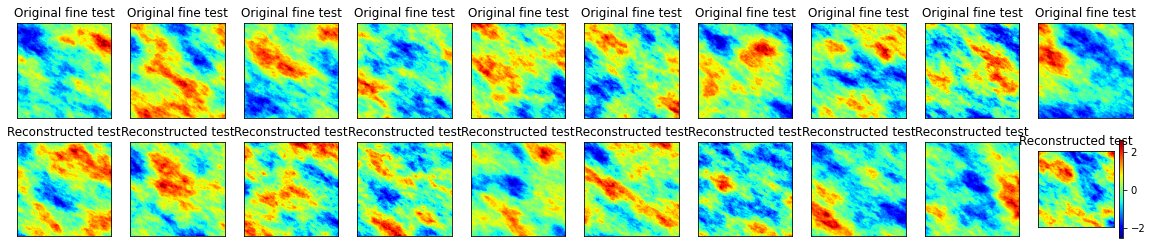

In [7]:
plot_reconstruction1(x_train,x_test,128,128)

(4500, 64, 64)
(500, 64, 64)
4.84133
-5.66942


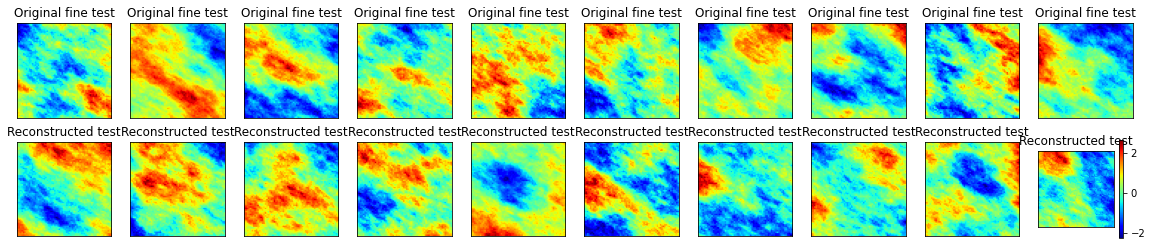

In [8]:
# Crop 64x64

x_train=x_train[:,32:96,32:96]
x_test=x_test[:,32:96,32:96]
print(x_train.shape)
print(x_test.shape)
print(x_train.max())
print(x_train.min())
plot_reconstruction1(x_train,x_test,64,64)

In [9]:
# Assign train data to 64x64

train64_64nd, test64_64nd=(x_train, x_test)
print(train64_64nd.shape)
print(np.histogram(train64_64nd))
print(train64_64nd.max())
print(train64_64nd.min())

(4500, 64, 64)
(array([    143,    2248,   85289, 1101297, 4889208, 7519845, 4048490,
        736990,   47729,     761], dtype=int64), array([-5.66942 , -4.618345, -3.56727 , -2.516195, -1.46512 , -0.414045,
        0.63703 ,  1.688105,  2.73918 ,  3.790255,  4.84133 ]))
4.84133
-5.66942


In [10]:
# upscale_reshape_normalize

train8_8dn, test8_8dn=upscale_normalize_reshape(train64_64nd,test64_64nd,(8,8),cnn=False)
train8_8cnndn, test8_8cnndn=upscale_normalize_reshape(train64_64nd,test64_64nd,(8,8),cnn=True)

train16_16dn, test16_16dn=upscale_normalize_reshape(train64_64nd,test64_64nd,(16,16),cnn=False)
train16_16cnndn, test16_16cnndn=upscale_normalize_reshape(train64_64nd,test64_64nd,(16,16),cnn=True)

train32_32dn, test32_32dn=upscale_normalize_reshape(train64_64nd,test64_64nd,(32,32),cnn=False)
train32_32cnndn, test32_32cnndn=upscale_normalize_reshape(train64_64nd,test64_64nd,(32,32),cnn=True)

train64_64dn, test64_64dn=upscale_normalize_reshape(train64_64nd,test64_64nd,(64,64),cnn=False)
train64_64cnndn, test64_64cnndn=upscale_normalize_reshape(train64_64nd,test64_64nd,(64,64),cnn=True)

#train28_28dn, test28_28dn=train28_28nd, test28_28nd
print(train8_8dn.shape)
print(train8_8cnndn.shape)
print(np.histogram(train8_8dn))
print(train16_16dn.shape)
print(np.histogram(train16_16dn))
print(train32_32dn.shape)
print(np.histogram(train32_32dn))
print(train64_64dn.shape)
print(np.histogram(train64_64dn))
print(train8_8dn.min())
print(train8_8dn.max())
print(train16_16dn.min())
print(train16_16dn.max())
print(train32_32dn.min())
print(train32_32dn.max())
print(train64_64dn.min())
print(train64_64dn.max())

(4500, 64)
(4500, 8, 8, 1)
(array([     6,     84,   2060,  18049,  67453, 106311,  71718,  19858,
         2330,    131], dtype=int64), array([-1.        , -0.8186204 , -0.63724077, -0.45586112, -0.2744815 ,
       -0.09310189,  0.08827773,  0.26965734,  0.451037  ,  0.6324166 ,
        0.8137962 ], dtype=float32))
(4500, 256)
(array([    14,    175,   5546,  61936, 269387, 448429, 289373,  70320,
         6573,    247], dtype=int64), array([-1.        , -0.81880665, -0.6376133 , -0.45641997, -0.27522665,
       -0.0940333 ,  0.08716004,  0.26835337,  0.44954672,  0.63074005,
        0.8119334 ], dtype=float32))
(4500, 1024)
(array([     46,     574,   20547,  253838, 1137248, 1845123, 1099580,
        232582,   18011,     451], dtype=int64), array([-1.        , -0.8170468 , -0.6340936 , -0.4511404 , -0.2681872 ,
       -0.08523399,  0.09771921,  0.28067243,  0.4636256 ,  0.64657885,
        0.829532  ], dtype=float32))
(4500, 4096)
(array([    143,    2248,   85289, 1101297, 4889208,

In [11]:
# Plot 3 large images
def plot_reconstruction1(original,reconstruction,dim1,dim2):


  n = 3
  plt.figure(figsize=(14, 7))
  for i in range(n):
      # Display original
      ax = plt.subplot(2, n, i + 1)
      plt.imshow(original[i].reshape(dim1, dim2))
      plt.jet()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      #plt.title('Original fine test')
      plt.title('Train')

      # Display reconstruction
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(reconstruction[i].reshape(dim1, dim2))
      plt.jet()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      #plt.title('Reconstructed test')
      plt.title('Test')
  plt.colorbar()
  plt.show()

# Import trained models (import, predict, plot)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8, 8, 1)]         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 32)          320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 32)          9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 32)          9248      
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 32)        4128      
_________________________________________________________________
reg7x7 (Conv2D)              (None, 16, 16, 1)         289       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        320   

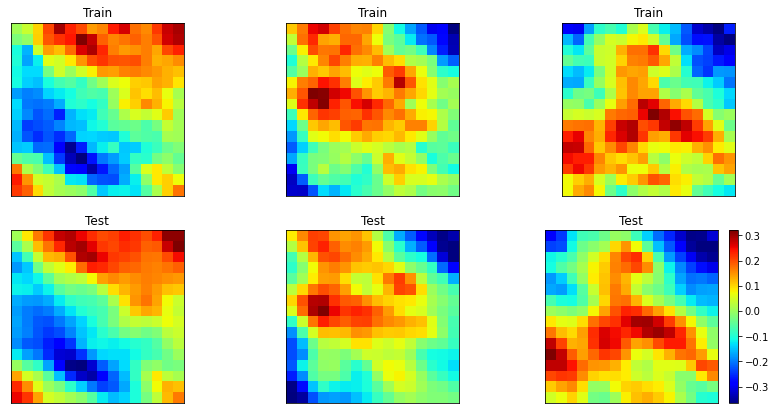

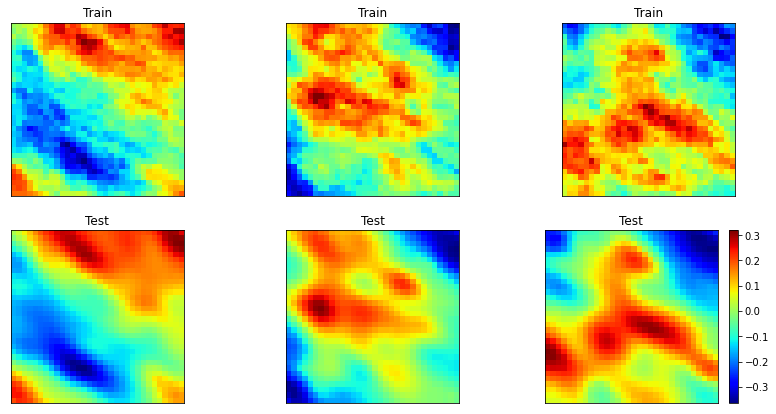

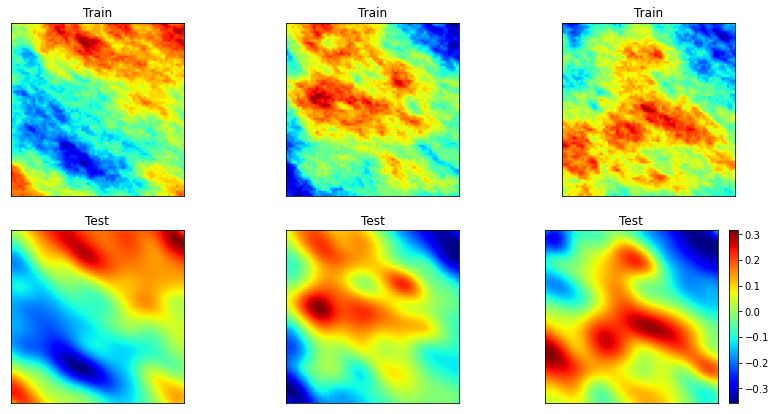

In [12]:
model_1 = keras.models.load_model('model_64x64_base_case_inv.h5')
model_1.summary()

pred16_16f5,pred32_32f5,pred64_64f5  = model_1.predict(test8_8cnndn)
print(pred16_16f5.shape)

#plot predictions from model
plot_reconstruction1(test16_16dn,pred16_16f5,16,16)
plot_reconstruction1(test32_32dn,pred32_32f5,32,32)
plot_reconstruction1(test64_64dn,pred64_64f5,64,64)

## Crop the model

In [13]:
# model_16_64

model_input16_64 = keras.Input(shape=(16,16,1)) #20

md16_64 = model_1.layers[-10](model_input16_64)
md16_64  = model_1.layers[-9](md16_64)
md16_64  = model_1.layers[-8](md16_64)
md16_64  = model_1.layers[-7](md16_64)
md16_64  = model_1.layers[-6](md16_64)
md16_64  = model_1.layers[-5](md16_64)
md16_64  = model_1.layers[-4](md16_64)
md16_64  = model_1.layers[-3](md16_64)
md16_64  = model_1.layers[-2](md16_64)
md16_64  = model_1.layers[-1](md16_64)

# create the decoder model
model_16_64= keras.Model(model_input16_64, md16_64)
model_16_64.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16, 16, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 32)        4128      
_________________________________________________________________
reg14x14 (Conv2D)            (None, 32, 32, 1)         289       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 32)        320   

In [14]:
# model_32_64

model_input32_64 = keras.Input(shape=(32,32,1)) #20

md32_64 = model_1.layers[-5](model_input32_64)
md32_64  = model_1.layers[-4](md32_64)
md32_64  = model_1.layers[-3](md32_64)
md32_64  = model_1.layers[-2](md32_64)
md32_64  = model_1.layers[-1](md32_64)

# create the decoder model
model_32_64= keras.Model(model_input32_64, md32_64)
model_32_64.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 64, 64, 32)        4128      
_________________________________________________________________
reg28x28 (Conv2D)            (None, 64, 64, 1)         289       
Total params: 23,233
Trainable params: 23,233
Non-trainable params: 0
_______________________________________________________

In [15]:
# model_16_32

model_input16_32 = keras.Input(shape=(16,16,1)) #20

md16_32 = model_1.layers[-10](model_input16_32)
md16_32  = model_1.layers[-9](md16_32)
md16_32  = model_1.layers[-8](md16_32)
md16_32  = model_1.layers[-7](md16_32)
md16_32  = model_1.layers[-6](md16_32)

# create the decoder model
model_16_32= keras.Model(model_input16_32, md16_32)
model_16_32.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 16, 16, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 32)        4128      
_________________________________________________________________
reg14x14 (Conv2D)            (None, 32, 32, 1)         289       
Total params: 23,233
Trainable params: 23,233
Non-trainable params: 0
_______________________________________________________

## Zone of influence: 1) 8-16  2) 8-32 3) 8-64  4) 16-32  5) 16-64  6) 32-64

# G and flow data

In [16]:
import scipy.io
G_global = scipy.io.loadmat('G1way_every8.mat')
G_global =G_global['G1way_every8']
print(G_global.shape)
print(type(G_global))

# 

(64, 4096)
<class 'numpy.ndarray'>


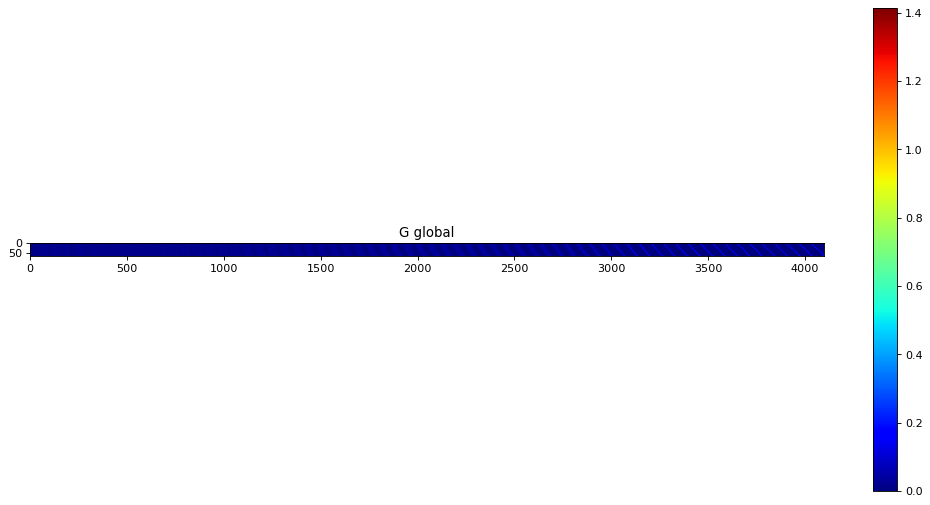

In [17]:
plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(G_global)
plt.jet()
plt.title('G global')
plt.colorbar()
plt.show()

In [18]:
for i in range(G_global.shape[0]):
    a=G_global[i,:]
    a=np.reshape(a,(64,64))
    a=a.T
    a=a.flatten()
    G_global[i,:]=a
print(G_global.shape)

(64, 4096)


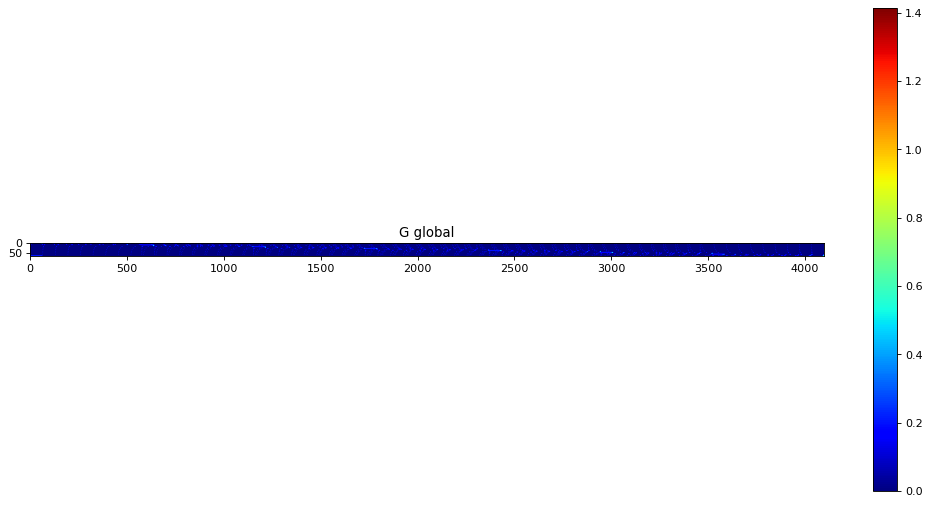

In [19]:
plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(G_global)
plt.jet()
plt.title('G global')
plt.colorbar()
plt.show()
G_global=G_global.T

In [20]:
import scipy.io
G_local = scipy.io.loadmat('G32_32_2way.mat')
G_local =G_local['G32_32_2way']
print(G_local.shape)
print(type(G_local))

# 

(2048, 1024)
<class 'numpy.ndarray'>


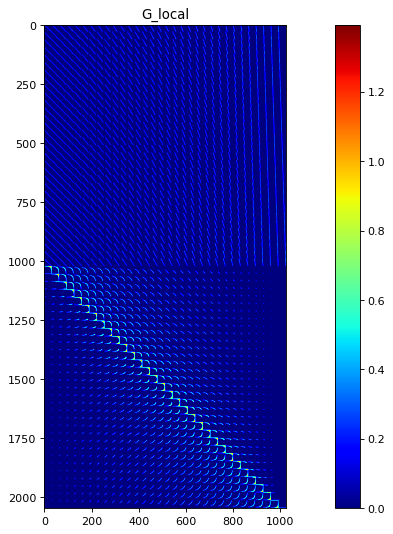

In [21]:
plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(G_local)
plt.jet()
plt.title('G_local')
plt.colorbar()
plt.show()

In [22]:
for i in range(G_local.shape[0]):
    a=G_local[i,:]
    a=np.reshape(a,(32,32))
    a=a.T
    a=a.flatten()
    G_local[i,:]=a
print(G_local.shape)

(2048, 1024)


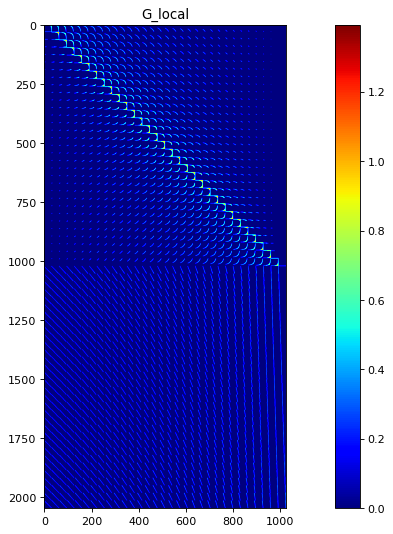

In [23]:
plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(G_local)
plt.jet()
plt.title('G_local')
plt.colorbar()
plt.show()
G_local=G_local.T

## Gradient-based data assimilation

(4096,)
-0.6413801
0.467241
--------------
-0.93263704-16-0.77803963
-0.9059925-32--0.9059925
-0.8916127-64--0.8916127


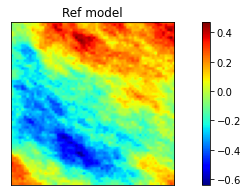

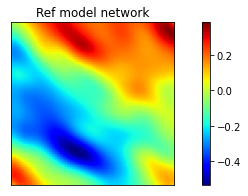

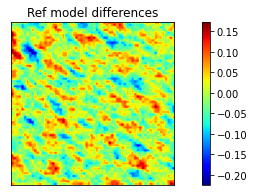

In [24]:
# Choose reference

ref=0

m_ref=np.squeeze(test64_64dn[ref:ref+1,:].T)
print(m_ref.shape)
print(m_ref.min())
print(m_ref.max())

# Plot reference

f = plt.figure(figsize=(10, 3))
plt.imshow(np.reshape(m_ref, [64, 64]),aspect='equal')
plt.xticks([]), plt.yticks([])
plt.colorbar()
plt.title("Ref model")

f = plt.figure(figsize=(10, 3))
plt.imshow(np.reshape(pred64_64f5[ref:ref+1,:], [64, 64]),aspect='equal')
plt.xticks([]), plt.yticks([])
plt.colorbar()
plt.title("Ref model network")

f = plt.figure(figsize=(10, 3))
plt.imshow((np.reshape(m_ref, [64, 64])-np.reshape(pred64_64f5[ref:ref+1,:], [64, 64])),aspect='equal')
plt.xticks([]), plt.yticks([])
plt.colorbar()
plt.title("Ref model differences")


print('--------------')
print(str(pred16_16f5.min())+'-16-'+str(pred16_16f5.max()))
print(str(pred32_32f5.min())+'-32-'+str(pred32_32f5.min()))
print(str(pred64_64f5.min())+'-64-'+str(pred64_64f5.min()))

In [25]:
# Generate flow data global

m_ref=np.squeeze(m_ref)
print(m_ref.shape)

d_obs_global = np.reshape(m_ref, [1, m_ref.shape[0]])@G_global
d_obs_global= np.squeeze(d_obs_global)



print(d_obs_global.shape) # (128,)
print(max(d_obs_global))
print(min(d_obs_global))


print(d_obs_global)


(4096,)
(64,)
13.497108255745843
-18.05201667692125
[ 13.46468068  12.2156431    8.30531233   4.55056913   0.4788474
  -3.39607837  -1.09537686  -0.8890899   12.45691259   9.52681752
   5.36216915   0.97623063  -3.1701651   -7.01749475  -5.02662872
  -2.96982853  12.37353493   6.97770796   1.53687151  -4.79573366
  -6.97133424  -7.74749084  -5.96331795  -4.41589236  10.35939106
   1.35667486  -4.48915473  -6.84470245  -7.8039604   -9.32408653
  -8.44412346  -8.02065718   6.20866416  -2.87134407  -5.77394478
  -8.84471125 -12.09319401 -13.69693357 -11.50374752  -9.79579151
   0.20350821  -8.15116952 -10.89529005 -12.33675601 -15.11503197
 -16.98602472 -14.63641873  -9.17702397  -5.80076073 -12.18212206
 -13.27081547 -16.3571093  -14.8932271  -15.6984464   -8.45518241
  -3.70645856  -4.96491856 -11.58300718 -10.76132129 -12.20809911
 -18.05201668 -16.08788312  -4.90373944  13.49710826]


In [26]:
# Generate flow data local
m_ref2=m_ref.copy()
m_ref2=np.reshape(m_ref2,(64,64))
m_ref2=m_ref2[0:32,0:32].flatten()
m_ref2=np.squeeze(m_ref2)
print(m_ref2.shape)

d_obs_local = np.reshape(m_ref2, [1, m_ref2.shape[0]])@G_local
d_obs_local= np.squeeze(d_obs_local)



print(d_obs_local.shape) # (128,)
print(max(d_obs_local))
print(min(d_obs_local))



print(d_obs_local)

(1024,)
(2048,)
7.052306975818009
-8.75322338938713
[5.0188168  5.0212668  4.37709675 ... 2.98954295 2.99101792 2.90701149]


## 8x8 Global

In [27]:
#callback to monitor optimization process
from IPython.display import clear_output

i8glob = 0
x8glo = []
losses8glo = []
logs8glo = []
grad8glo=[]
interm_sol8glo=[]
interm_sol64_8glo=[]
grad_v8glo=[]

def monitor8global(xk):
    
    global i8glob, x8glo, losses8glo, logs8glo, grad8glo, interm_sol8glo, interm_sol64_8glo, grad_v8glo
    
    fig = plt.figure(figsize=[15, 4])

    logs8glo.append(logs8glo)
    x8glo.append(i8glob)
    losses8glo.append(func8global(xk))
    i8glob += 1
    grad8glo.append(np.linalg.norm(dldm8global(xk)))
    
    clear_output(wait=True)
    
    plt.subplot(1, 3, 1)
    plt.plot(x8glo, losses8glo, label="loss", c = 'green')
    plt.ylabel("Loss function")
    plt.xlabel("Iter.")
    plt.title("Loss vs iter.")
    
    
    plt.subplot(1, 3, 2)
    plt.imshow(np.reshape(xk, [8, 8]), aspect='equal')
    plt.xticks([]), plt.yticks([])
    plt.title("Inv. model 8x8")
    #plt.clim(0, 1)
    plt.colorbar()
    

    interm_sol8glo.append(xk)
    xk=np.reshape(xk,(1,8,8,1))
    grad8glo.append(dldm8global(xk))
    xk = model_1.predict(xk)[2]
    interm_sol64_8glo.append(xk)
    
    
    plt.subplot(1, 3, 3)
    plt.imshow(np.reshape(xk, [64, 64]), aspect='equal')
    plt.xticks([]), plt.yticks([])
    plt.title("Inv. model 64x64")
    #plt.clim(0, 1)
    plt.colorbar()
    plt.show()
    

In [28]:
#objective function
def func8global(z8): #m5: 25-dimensional vector
    #if (z5.max()==0):
     #   z5=z5
    #else:
     #   z5=z5/z5.max()
    z8cnn=np.reshape(z8,(1,8,8,1))
    pred64_64f5_1  = model_1.predict(z8cnn)[2]
    m64=np.squeeze(pred64_64f5_1)
    m64=np.reshape(m64,[m64.shape[0]*m64.shape[0],])
    obj=np.sqrt(np.mean(np.square(G_global.T@m64 - d_obs_global)))
    
    return obj

In [29]:
#gradient of function

def dldm8global(z8):

    grad_L=np.zeros((64,1))
    z8=np.reshape(z8,(64,1))
    m01=np.zeros((64,1))
    m02=np.zeros((64,1))
    s8=np.reshape(np.arange(0,64),[8,8])
    for i in range(8):
        for j in range(8):
            dx=0.05
            dum1=np.zeros((64,1))
            dum1[s8[i][j],0]=dx
            m01=z8+dum1
            m02=z8-dum1
            L1=func8global(m01)
            L2=func8global(m02)
            grad_L[s8[i][j]]=(L1-L2)/(2*dx)
    grad_L=np.squeeze(grad_L)
    
    #print(grad_L)
    return grad_L

In [30]:
from scipy.optimize import Bounds
bounds8 =()
mm=[-1,1]
for i in range(64):
    bounds8=bounds8+(mm,)
print(bounds8)
len(bounds8)

([-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1])


64

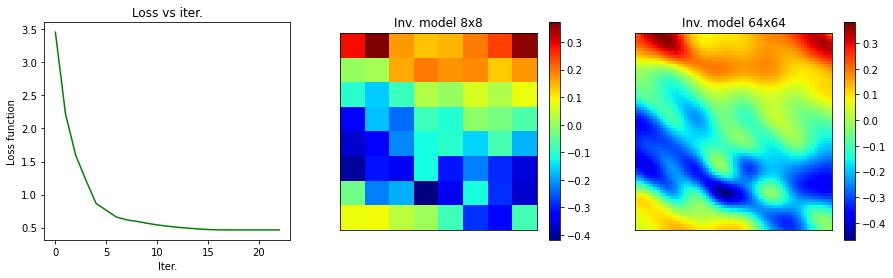

(64, 1)


In [31]:
# optimization; add time

#initial guess (sensitive!)
m08glo = np.zeros([64, 1])
#m08glo=np.reshape(m0_ens8x8,[64,1])
print(m08glo.shape)


#minimize the objective function
res8glob = minimize(func8global, m08glo, method='L-BFGS-B', jac=dldm8global, callback=monitor8global, options={'gtol': 1e-2, 'disp': True},bounds=bounds8)


m_sol8glo = np.expand_dims(res8glob.x, axis=-1)
print(m_sol8glo.shape)

In [32]:
from winsound import Beep
Beep(1000,1000)

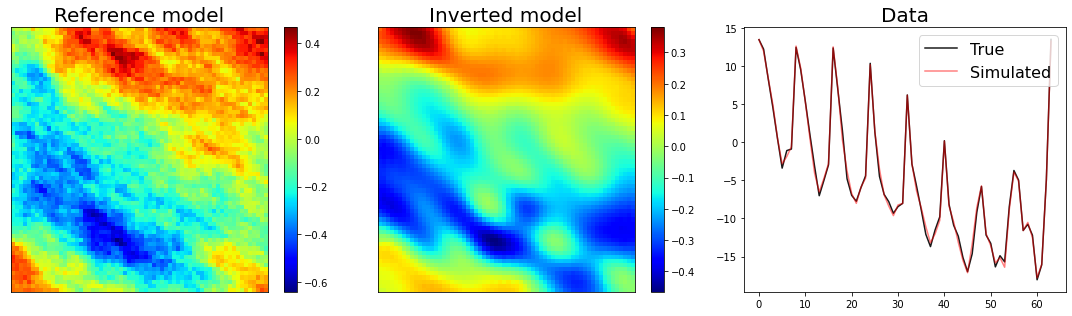

In [45]:
#forward simulation on the inverted model
m_sol8glo=np.reshape(m_sol8glo,(1,8,8,1))
m_sol64_8glo  = model_1.predict(m_sol8glo)[2]
m_sol64_8glo=np.squeeze(np.reshape(m_sol64_8glo,[64*64,]))
y_sim8glo = (m_sol64_8glo.T@G_global).T

#compare model and data (i.e. reference case vs solution)
from matplotlib.patches import Rectangle
from PIL import Image
f = plt.figure(figsize=(15, 4.5))
plt.subplot(1, 3, 1)
plt.imshow(np.reshape(m_ref, [64, 64]), aspect='auto')
#plt.gca().add_patch(Rectangle((0,0),32,32,linewidth=4,edgecolor='r',facecolor='none'))
plt.xticks([]), plt.yticks([])
plt.title("Reference model",fontsize = 20)
plt.colorbar(shrink=1)

plt.subplot(1,3, 2)
#m_sol64_8glo[abs(m_sol64_8glo) < 0.02] = np.nan # or use np.nan
plt.imshow(np.reshape(m_sol64_8glo, [64, 64]), aspect='auto')
#current_cmap = plt.cm.get_cmap()
#current_cmap.set_bad(color='white')
#plt.gca().add_patch(Rectangle((0,0),32,32,linewidth=5,edgecolor='r',facecolor='none'))
plt.xticks([]), plt.yticks([])
plt.title("Inverted model",fontsize = 20)
plt.colorbar(shrink=1)

plt.subplot(1, 3, 3)
plt.plot(d_obs_global, ls='-', c='k', label='True', alpha=0.9)
plt.plot(y_sim8glo, c='r', label='Simulated', alpha=0.5)
plt.title("Data",fontsize = 20)
plt.legend(loc=1, prop={'size': 16})

plt.tight_layout()
plt.savefig('Results4_global_8',dpi=500)

In [34]:
## Metric
model_metric_8glob=np.mean(np.square(m_sol64_8glo-m_ref))
model_metric_8glob = "{:.4f}".format(model_metric_8glob)    
data_metric_8glob=np.mean(np.square(d_obs_global-y_sim8glo))
data_metric_8glob = "{:.4f}".format(data_metric_8glob)
print(m_sol64_8glo.shape)
print(m_ref.shape)
print(d_obs_global.shape)
print(y_sim8glo.shape)
print('model error 8glob RSE:'+str(model_metric_8glob))
print('data  error 8glob RSE:'+str(data_metric_8glob))

(4096,)
(4096,)
(64,)
(64,)
model error 8glob RSE:0.0194
data  error 8glob RSE:0.2160


## Transition

(1, 16, 16, 1)
(1, 64, 64, 1)


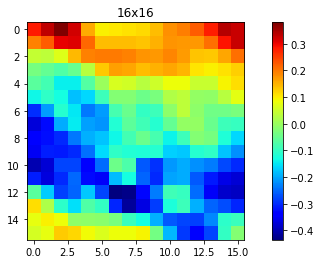

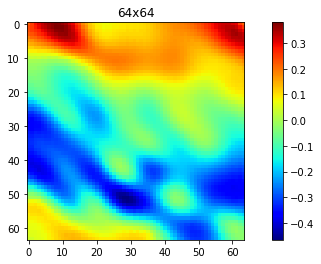

In [35]:
m16glo  = model_1.predict(m_sol8glo)[0]
print(m16glo.shape)
#m10cnn=np.reshape(m10,(1,10,10,1))
pred64_64f16_glo  = model_16_64.predict(m16glo)
print(pred64_64f16_glo.shape)

# Display reconstruction
plt.figure(figsize=(10, 4))
#plt.subplot(1, 2, 1)
plt.imshow(m16glo.reshape(16, 16))
plt.jet()
#ax.get_xaxis().set_visible(False)
#ax.get_yaxis().set_visible(False)
plt.title('16x16')
plt.colorbar()
plt.show()

# Display reconstruction
plt.figure(figsize=(10, 4))
#plt.subplot(1, 2, 2)
plt.imshow(pred64_64f16_glo.reshape(64, 64))
plt.jet()
#ax.get_xaxis().set_visible(False)
#ax.get_yaxis().set_visible(False)
plt.title('64x64')
plt.colorbar()
plt.show()

## 16x16 local

In [36]:
#callback to monitor optimization process
from IPython.display import clear_output

i16glob = 0
x16glo = []
losses16glo = []
logs16glo = []
grad16glo=[]
interm_sol16glo=[]
interm_sol64_16glo=[]
grad_v16glo=[]

def monitor16global(xk):
    
    global i16glob, x16glo, losses16glo, logs16glo, grad16glo, interm_sol16glo, interm_sol64_16glo, grad_v16glo
    
    fig = plt.figure(figsize=[15, 4])

    logs16glo.append(logs16glo)
    x16glo.append(i16glob)
    losses16glo.append(func16global(xk))
    i16glob += 1
    grad16glo.append(np.linalg.norm(dldm16global(xk)))
    
    clear_output(wait=True)
    
    plt.subplot(1, 3, 1)
    plt.plot(x16glo, losses16glo, label="loss", c = 'green')
    plt.ylabel("Loss function")
    plt.xlabel("Iter.")
    plt.title("Loss vs iter.")
    
    
    plt.subplot(1, 3, 2)
    plt.imshow(np.reshape(xk, [16, 16]), aspect='equal')
    plt.xticks([]), plt.yticks([])
    plt.title("Inv. model 16x16")
    #plt.clim(0, 1)
    plt.colorbar()
    

    interm_sol16glo.append(xk)
    xk=np.reshape(xk,(1,16,16,1))
    grad16glo.append(dldm16global(xk))
    xk = model_16_64.predict(xk)
    interm_sol64_16glo.append(xk)
    
    
    plt.subplot(1, 3, 3)
    plt.imshow(np.reshape(xk, [64, 64]), aspect='equal')
    plt.xticks([]), plt.yticks([])
    plt.title("Inv. model 64x64")
    #plt.clim(0, 1)
    plt.colorbar()
    plt.show()

In [37]:
#objective function
def func16global(z16): #m5: 25-dimensional vector
    #if (z5.max()==0):
     #   z5=z5
    #else:
     #   z5=z5/z5.max()
    z16cnn=np.reshape(z16,(1,16,16,1))
    pred64_64f16_1  = model_16_64.predict(z16cnn)
    m64=np.reshape(pred64_64f16_1,(64,64))
    m64=m64[0:32,0:32]
    m64=m64.flatten()
    m64=np.squeeze(m64)
    obj=np.sqrt(np.mean(np.square(G_local.T@m64 - d_obs_local)))
    
    return obj

In [38]:
#gradient of function

def dldm16global(z16):

    grad_L=np.zeros((256,1))
    z16=np.reshape(z16,(256,1))
    m01=np.zeros((256,1))
    m02=np.zeros((256,1))
    s16=np.reshape(np.arange(0,256),[16,16])
    for i in range(8):
        for j in range(8):
            dx=0.05
            dum1=np.zeros((256,1))
            dum1[s16[i][j],0]=dx
            m01=z16+dum1
            m02=z16-dum1
            L1=func16global(m01)
            L2=func16global(m02)
            grad_L[s16[i][j]]=(L1-L2)/(2*dx)
    grad_L=np.squeeze(grad_L)
    
    print(grad_L)
    return grad_L



In [39]:
bounds16 =()
mm=[-1,1]
for i in range(256):
    bounds16=bounds16+(mm,)
print(bounds16)
len(bounds16)

([-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], 

256

[-0.00910308 -0.00027702  0.00095047  0.00464409  0.00760739  0.00616274
  0.00982952  0.00923731  0.          0.          0.          0.
  0.          0.          0.          0.         -0.00417038 -0.00044741
 -0.01455182  0.01209117  0.005688    0.01541375  0.01427761  0.01299519
  0.          0.          0.          0.          0.          0.
  0.          0.          0.00627987 -0.00133594 -0.00337669  0.00209322
  0.00964671  0.00470435  0.00436965 -0.0023946   0.          0.
  0.          0.          0.          0.          0.          0.
 -0.00019612  0.00535751  0.00227867  0.01428557  0.04180612  0.00519511
  0.00657145 -0.00175363  0.          0.          0.          0.
  0.          0.          0.          0.         -0.00938724  0.00154581
  0.00078501  0.01098156 -0.00215617  0.01862477 -0.00166436 -0.00379164
  0.          0.          0.          0.          0.          0.
  0.          0.         -0.02162156 -0.00531279 -0.00805358  0.01492527
  0.01710921  0.00456999  

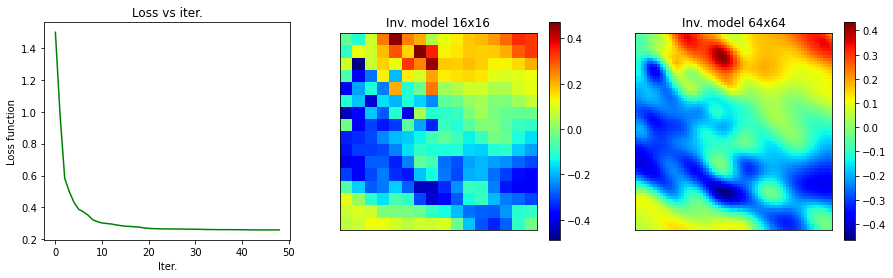

(256, 1)


In [40]:
# optimization; add time

#initial guess (sensitive!)
m016_glo = np.reshape(m16glo,[256,1])
#m05=np.reshape(m0_ens5x5,[25,1])
print(m016_glo.shape)


#minimize the objective function
res16_glo = minimize(func16global, m016_glo, method='L-BFGS-B', jac=dldm16global, callback=monitor16global, options={'gtol': 1e-2, 'disp': True},bounds=bounds16)


m_sol16_glo = np.expand_dims(res16_glo.x, axis=-1)
print(m_sol16_glo.shape)

In [41]:
from winsound import Beep
Beep(1000,1000)

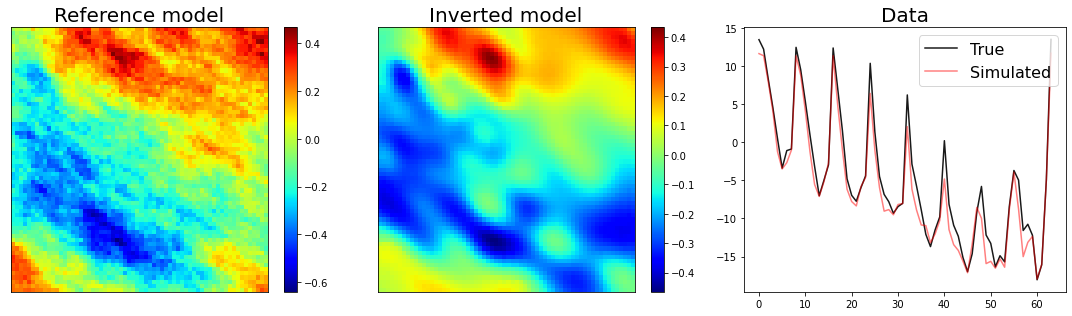

In [46]:
#forward simulation on the inverted model
m_sol16glo=np.reshape(m_sol16_glo,(1,16,16,1))
m_sol64_16glo  = model_16_64.predict(m_sol16glo)
m_sol64_16glo=np.squeeze(np.reshape(m_sol64_16glo,[64*64,]))
y_sim16glo = (m_sol64_16glo.T@G_global).T

#compare model and data (i.e. reference case vs solution)
from matplotlib.patches import Rectangle
from PIL import Image
f = plt.figure(figsize=(15, 4.5))
plt.subplot(1, 3, 1)
plt.imshow(np.reshape(m_ref, [64, 64]), aspect='auto')
#plt.gca().add_patch(Rectangle((0,0),32,32,linewidth=4,edgecolor='r',facecolor='none'))
plt.xticks([]), plt.yticks([])
plt.title("Reference model",fontsize = 20)
plt.colorbar(shrink=1)

plt.subplot(1,3, 2)
#m_sol64_8glo[abs(m_sol64_8glo) < 0.02] = np.nan # or use np.nan
plt.imshow(np.reshape(m_sol64_16glo, [64, 64]), aspect='auto')
#current_cmap = plt.cm.get_cmap()
#current_cmap.set_bad(color='white')
#plt.gca().add_patch(Rectangle((0,0),32,32,linewidth=5,edgecolor='r',facecolor='none'))
plt.xticks([]), plt.yticks([])
plt.title("Inverted model",fontsize = 20)
plt.colorbar(shrink=1)

plt.subplot(1, 3, 3)
plt.plot(d_obs_global, ls='-', c='k', label='True', alpha=0.9)
plt.plot(y_sim16glo, c='r', label='Simulated', alpha=0.5)
plt.title("Data",fontsize = 20)
plt.legend(loc=1, prop={'size': 16})

plt.tight_layout()
plt.savefig('Results4_local_16',dpi=500)

In [43]:
## Metric
model_metric_16glob=np.mean(np.square(m_sol64_16glo-m_ref))
model_metric_16glob = "{:.4f}".format(model_metric_16glob)    
data_metric_16glob=np.mean(np.square(d_obs_global-y_sim16glo))
data_metric_16glob = "{:.4f}".format(data_metric_16glob)
print(m_sol64_16glo.shape)
print(m_ref.shape)
print(d_obs_global.shape)
print(y_sim16glo.shape)
print('model error 16glob RSE:'+str(model_metric_16glob))
print('data  error 16glob RSE:'+str(data_metric_16glob))

(4096,)
(4096,)
(64,)
(64,)
model error 16glob RSE:0.0141
data  error 16glob RSE:3.6583


In [ ]:
from winsound import Beep
Beep(1000,1000)